# Dimensionality Reduction

Now we'll work through an example of _unsupervised learning_. Recall unsupervised learning deals with situations in which we have no information on what the labels are, i.e. we're given only the inputs in our dataset. Unsupervised learning is essentially an umbrella term that covers three different tasks. One task is _dimensionality reduction_, where we seek to reduce the dimension of our dataset. The reasons we may wish to do something like this include reducing the memory load of the data, trying to eliminate noise from the data, or trying to visualize high-dimensional data. Another task of unsupervised learning is _clustering_. Clustering involves trying to find underlying patterns in the input data, and using these patterns to infer what our unknown labels are. The last task of unsupervised learning is _density estimation_, i.e. inferring what the underlying joint distribution of the data is.

In this notebook we'll focus on dimensionality reduction. DR is useful for three things in particular:
1. Compression: DR allows you to take data with a large number of features (like images) and express them as faithfully as possible with a much smaller number of projected features.
2. Denoising: If your dataset has a lot of noise, DR is one thing you can try to get rid of some of that noise.
3. Data Visualization: Humans can only visualize things in 1-3 dimensions. DR allows you to project any number of features down to just 2-3 features that you can easily visualize.

As usual, we begin by loading in the packages we'll use and setting the seed. We can use sklearn to do most types of DR you'd ever want to do.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_mldata
np.random.seed(42)

We next define several functions we'll be using. The first loads in the data and does some downsampling and rescaling of the data. The rest are various plots we'll be using below.

In [9]:
def get_data():
    mnist = fetch_mldata('MNIST original')
    down_sample = np.random.choice(len(mnist.data),5000,replace=False)
    X = mnist.data[down_sample].astype(np.float64)
    X = MinMaxScaler(feature_range=(0,1)).fit_transform(X)
    return X

def plot_images(X, n=4):
    idx = np.random.choice(len(X),n**2,replace=False)
    _,ax = plt.subplots(nrows=n,ncols=n)#,figsize=(4, 4))
    cnt = 0
    for i in range(n):
        for j in range(n):
            ax[i,j].imshow(X[idx[cnt]].reshape(28,28), aspect='auto', cmap=cm.gray)
            ax[i,j].axis('off')
            cnt += 1
    plt.show()

def pca_plot(X, max_dims=100):
    N = min(X.shape[1],max_dims)
    pca = PCA(n_components=N)
    pca.fit(X)
    plt.plot(range(1,N+1),pca.explained_variance_ratio_)
    plt.xlim(0,N+1)
    plt.locator_params(axis='x', nbins=40)
    plt.xlabel('principal components')
    plt.ylabel('% of variance explained')
    plt.show()
    
def plot_reduced_2D(X_dr, dr_type):
    plt.scatter(X_dr[:,0],X_dr[:,1],s=0.5,alpha=0.5)
    plt.title(dr_type+' with 2 components')
    plt.show()

We'll be working with the well-known MNIST dataset, which contains images (28x28 pixel grayscale) of handwritten digits. This dataset was chosen because it has lots of features ($784=28 \times 28$), isn't too noisy, and because it's at least worth knowing about how to do ML with images and this is perhaps the simplest image dataset out there.

We load the images into `X`. Each row of `X` is an image. Each column is a pixel (flattened from 28x28 to 784). Next a few randomly sampled images from this set are plotted so you can see that they are in fact handwritten digits.

Shape of X: (5000, 784)
Number of samples (images): 5000
Number of features (pixels): 784


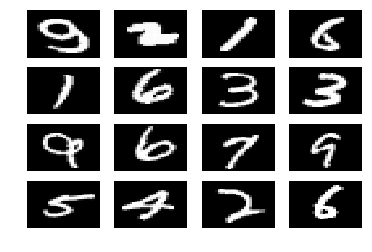

In [10]:
X = get_data()
print('Shape of X:',X.shape)
print('Number of samples (images):',X.shape[0])
print('Number of features (pixels):',X.shape[1])
plot_images(X)

**Important Note:** Before most DR methods on your data, it's essential that you normalize it first so that all your features are on the same scale, otherwise you're likely to get poor results. 

The most common way to do this is _standardizing_ your data. That is, for each feature $x_i$ (i.e. column of your data) you'll want to do
$$ x_i \gets \frac{x_i-\text{mean}(x_i)}{\text{stdev}(x_i)}.$$
This makes it so each column of your data has mean 0 and standard deviation 1. With sklearn you can do this automatically with the `sklearn.preprocessing.StandardScaler` class.

Another way to normalize your data is to have all your values be between 0 and 1. You can do this by
$$ x_i \gets \frac{x_i - \min(x_i)}{\max{x_i} - \min{x_i}}.$$
For images it's better to normalize between 0 and 1, so that's what we do here. With sklearn you can do this automatically with the `sklearn.preprocessing.MinMaxScaler` class.

The first DR technique we look at is _principle components analysis_, which is by far the most commonly known about DR method and by far the most commonly used in practice. PCA works by finding the best _linear_ subspace on which to project the data. PCA is fast compared to other DR methods, but the linear projection makes it limited in how much structure it can pick up.

First, we do PCA 100 times. For each $i=1,\dots,100$, we project PCA onto the top $i$ dimensions only. The top $i$ dimensions contain most of the structure of the data. The higher $i$ is, the more structure you keep. The goal is to find an $i$ just high enough to capture most of the structure in your data, but no higher than that. We can determine this visually by looking at a plot of the percent of variance retained. In the plot we're looking for an "elbow" as a good choice for $i$. In this case, I'd say any value between $i=5$ and $i=30$ is reasonable if you want to most of the structure in your data.

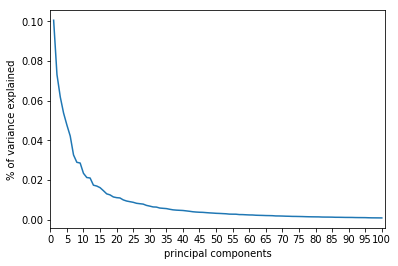

In [20]:
pca_plot(X)

While projecting onto dimensions between 5 and 30 is probably best for compression or noise reduction, for data viz we usually want to project onto the top 2 dimensions only since we can plot those easily. For this reason, we do all projections below onto the top 2 dimensions only. If you care less about data viz and more about compression or denoising, you'll probably want to keep a lot more.

Below we use sklearn to do this 2D PCA and get our dimension-reduced dataset `X_dr`. We then plot this 2D dataset. You can think of this plot as the "best linear 2D representation of your data".

X_dr shape:  (5000, 2)
X shape:  (5000, 784)


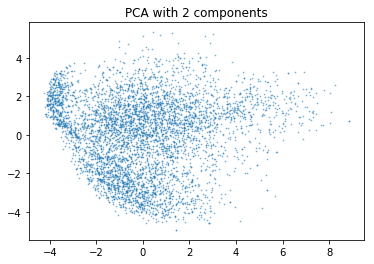

In [21]:
dr = PCA(n_components=2)
dr.fit(X)
X_dr = dr.transform(X)

print('X_dr shape: ',X_dr.shape)
print('X shape: ',X.shape)
plot_reduced_2D(X_dr, 'PCA')

The greatest limitation of PCA is that projections are always linear. To get non-linear projections we have to use different DR techniques. One popular such non-linear technique is ISOMAP. ISOMAP works by finding the best `n_components`-dimensional _manifold_ and projecting the data onto that manifold. The API to do this is basically the same. Notice that this runs much slower than PCA. That's a huge disadvantage of non-linear DR methods.

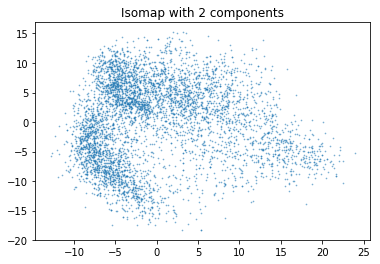

In [22]:
dr = Isomap(n_components=2, n_neighbors=30)
dr.fit(X)
X_dr = dr.transform(X)
plot_reduced_2D(X_dr, 'Isomap')

Another non-linear DR method is _locally linear embedding_. LLE tries to do the same type of thing as ISOMAP, but in a different way. Look the details up if you're interested. Note there are different variants of LLE, hence we specify here to use the standard one.

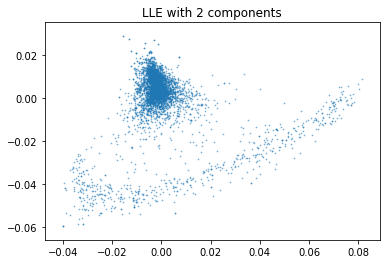

In [24]:
dr = LocallyLinearEmbedding(n_components=2, n_neighbors=30, method = 'standard')
dr.fit(X)
X_dr = dr.transform(X)
plot_reduced_2D(X_dr, 'LLE')

The last DR technique we mention is the _t-distributed stochastic non-linear embedding_, or _t-SNE_. t-SNE is probably the best data viz projection technique there is. It tends to maintain the structure of your data really well. Its disadvantages are that it's very SLOW to run usually, and that it's stochastic, meaning that each time you run it you'll get somewhat different projections! For this reason it's only really useful for data viz, and not much else. Nevertheless, if you're doing data viz this is one of the first things you should try.

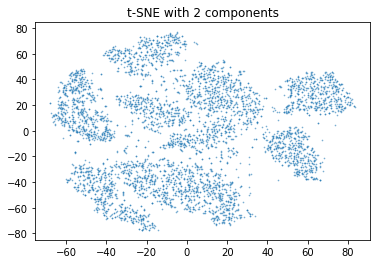

In [25]:
dr = TSNE(n_components=2, init='pca')
X_dr = dr.fit_transform(X)
plot_reduced_2D(X_dr, 't-SNE')